In [174]:
%%html
<style>
table {float:left}
</style>

#  Notebook 2: Classifier Analysis

In this notebook I want to complete the following things:

> *Analyse the performance of the classifiers (expected content in hand-in: code, 2-5 bullet-points and 1-3 tables/figures)*
>
> *Find the optimum thresholds to distinguish the undamaged/repair/replace classes. You are free to choose any objective here (accuracy, true positive rate, etc.) but make sure to justify your choice, and that the justification is sensible (expected content in hand-in: code, 2-5 bullet-points and 1-3 tables/figures)*


#### Key Findings:

TODO: ADD STUFF HERE

#### Methodology:
* loading data
* split data into sub-tasks (undamaged vs repair, undamaged vs replace, repair vs replace)
* calculating ROC graphs for each task 
* calculate AOC for each 
* conduct sanity checks

#### Project structure:
```
/venv
/tractable_ds_excercise_data
/combined_data.csv (created from data_processing.ipynb)
/data_processing.ipynb
/classifier_analysis.ipynb (this notebook)
```

#### Assumptions made:

* Acceptable to seperate problem into two main subproblems (undamaged vs repair) and (repair vs replace)
* We conduct all analysis only on the validation set. An additional task may to be validate this performance on training



In [202]:
!pip install pandas
!pip install sklearn
!pip install numpy
!pip install matplotlib
!pip install tqdm
%matplotlib inline 

import pandas
import sklearn
import numpy as np

  Using cached tqdm-4.54.1-py2.py3-none-any.whl (69 kB)


In [203]:
# loading data
df = pandas.read_csv('./combined_data.csv')
df['urr_score'] = df['urr_score'].fillna(0)
test_df = df[df['set']==2]
val_df = df[df['set']==1]

In [173]:
test_df, val_df

(        Unnamed: 0  claim_id     part  urr_score  set  operation
 110            110        11  fbumper   0.000000    2          0
 111            111        11  bbumper   0.779752    2          2
 112            112        11   bldoor   0.000000    2          0
 113            113        11   brdoor   0.300587    2          0
 114            114        11   frdoor   0.183560    2          0
 ...            ...       ...      ...        ...  ...        ...
 999935      999935     99993   fldoor   0.371724    2          0
 999936      999936     99993   frwing   0.669141    2          0
 999937      999937     99993   flwing   0.403251    2          0
 999938      999938     99993   brwing   0.045307    2          0
 999939      999939     99993   blwing   0.000000    2          0
 
 [100340 rows x 6 columns],
         Unnamed: 0  claim_id     part  urr_score  set  operation
 90              90         9  fbumper   0.000000    1          0
 91              91         9  bbumper   0.334

In [75]:
from sklearn import metrics

scores = val_df['urr_score'].to_numpy()
y = val_df['operation'].to_numpy()

## Approach to Analysis

We consider two simpler classification problems:

1. Undamaged vs Repair 
2. Repair vs Replace

This comes from the assumption that we have a paritial ordering of thresholds: undamaged < repair < replace

### Metrics to create:

1. Before calculating thresholds we'll produce the Receiver Operating Characteristic (ROC) for each classifier
2. Calculate the area under the curve (AOC) for each graph -> this is a probablistic interpretation of the classifier quality.

### Sanity Checks:

We should validate our assumptions:

1. Combining repair+replace and calculate the AOC_ROC for this graph. We'd expect this to be strictly better or equivilant to either subproblem.
2. Evaluating undamaged vs replace. Given that these categories should be distinctly seperate (with repair inbetween), we'd expect the best aoc score in this task.


In [192]:
def roc_graph(_y: np.ndarray, _scores: np.ndarray, title: str) -> plt.plot:
    tpr, fpr, threshold = metrics.roc_curve(_y, _scores, drop_intermediate=False)
    aoc = sklearn.metrics.roc_auc_score(_y, _scores)
    plt.plot(tpr, fpr, lw=2, color='darkorange', label=f'ROC curve (area = {round(aoc,4)})')
    plt.title(title)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(loc="lower right")
    
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, threshold, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([threshold[-1],threshold[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])
    return plt

##  ROC analysis

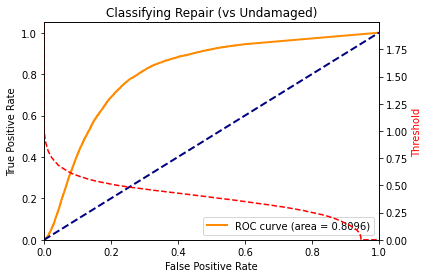

In [193]:
# undamanged vs repair 
remove_index = np.where(y == 2)
_y, _score = np.delete(y, remove_index), np.delete(scores,remove_index)
plt = roc_graph(_y, _score, "Classifying Repair (vs Undamaged)")

ROC_AUC: 0.8476566067414483


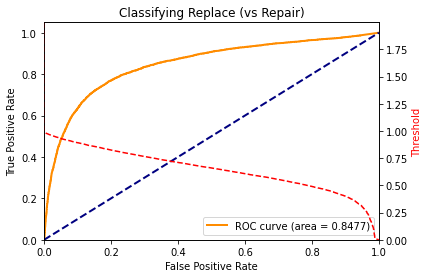

In [194]:
# repair vs replace 

remove_index = np.where(y == 0)
_y, _score = np.delete(y, remove_index), np.delete(scores,remove_index)
_y = _y -1
plt = roc_graph(_y, _score, "Classifying Replace (vs Repair)")
print(f"ROC_AUC: {sklearn.metrics.roc_auc_score(_y, _score)}")

## Sanity Checks

ROC_AUC: 0.9443124266044206


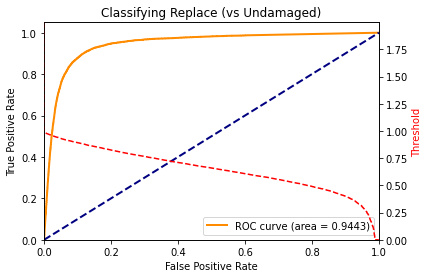

In [195]:
# undamanged vs replace 

remove_index = np.where(y == 1)
_y, _score = np.delete(y, remove_index), np.delete(scores,remove_index)
_y = np.where(_y==2, 1, _y)

plt = roc_graph(_y, _score, "Classifying Replace (vs Undamaged)")
print(f"ROC_AUC: {sklearn.metrics.roc_auc_score(_y, _score)}")


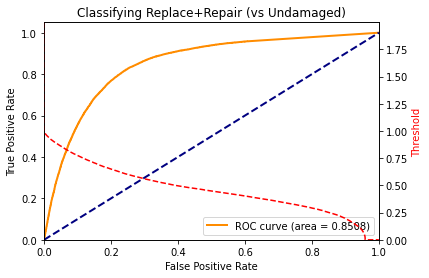

In [196]:
# (undamaged vs damaged)
_y = np.where(y==2, 1, y)
plt = roc_graph(_y, scores, "Classifying Replace+Repair (vs Undamaged)")

## Calculating Optimal Threshold


Calculating the optimal threshold requires us to define a metric to optimise. Before we jump it's important to remember the business case here - to correctly identify repairs and replacements. 

I'd argue that being eager to repair and replace allows our system to rarely be wrong (replacing/reparing when unncessary costs the insurance company but means claiments do not sucrentise our work).

To care about below are candidates:

#### Accuracy 
This is calculate as (TP/(TP+FP)). I'm going to stay away from this because the data is imbalanced, (see notebook 1 for data breakdown).

#### Precision
#### Recall
#### F1-Score (harmonic mean of Precision + Recall)
#### MCC Score

In [ ]:
# Assume accuracy for the moment and lets look only at Undamaged Vs Replace
from sklearn.metrics import matthews_corrcoef, f1_score
from tqdm.notebook import tqdm

remove_index = np.where(y == 2)
_y, _score = np.delete(y, remove_index), np.delete(scores,remove_index)
tpr, fpr, threshold = metrics.roc_curve(_y, _score, drop_intermediate=False)


metric = []
for t in tqdm(threshold):
    y_pred = np.where(_score>t, 1, 0)
    metric.append(f1_score(_y, y_pred))
